In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from blendhunter.config import BHConfig
from blendhunter.performance import get_acc

In [2]:
bhconfig = BHConfig(config_file='../data/bhconfig.yml').config
in_path = bhconfig['in_path']
out_path = bhconfig['out_path']
noise_sigma = bhconfig['noise_sigma']
n_noise_real = bhconfig['n_noise_real']
sample_range = slice(*bhconfig['sample_range'])

In [3]:
labels = np.load(os.path.join(out_path, 'bh_pad50/BlendHunterData/test/test/labels.npy')).flatten()

In [4]:
def get_distances(path, sample_range):
    
    param_x, param_y = [np.load(os.path.join(in_path, file_name), allow_pickle=True)[sample_range].flatten() 
                        for file_name in ('param_x_total.npy', 'param_y_total.npy')]
    
    return np.array([np.sqrt(x ** 2 + y ** 2) for x, y in zip(param_x, param_y)])

In [5]:
dist = get_distances(in_path, sample_range)

In [6]:
bh_res = get_acc('bh_pad_results', out_path, noise_sigma, 1, labels, return_type='retrieval', average=False)
sep_res = get_acc('sep_pad_results', out_path, noise_sigma, 1, labels, return_type='retrieval', average=False)

In [7]:
def make_hist(ax, dist_data, bh_data, sep_data, sigma_val):
    
    font = {'family': 'monospace',
            'color':  'k',
            'weight': 'normal',
            'size': 18}
    
    bh_dist_fail = dist[np.invert(bh_data)]
    sep_dist_fail = dist[np.invert(sep_data)]
    
    ax.set_title('sigma_noise = {}'.format(sigma_val), fontdict=font, fontsize=15.5)
    ax.hist(dist_data, color = 'steelblue', edgecolor = 'black', bins = int(180/3), label='Total dataset')
    ax.hist(sep_dist_fail, color = 'r', edgecolor = 'black', bins = int(180/3), label='SExtractor errors')
    ax.hist(bh_dist_fail, color = 'y', edgecolor = 'black', bins = int(180/3), label='BH errors')
    ax.set_xlabel('Distance between objects (pixels)', fontdict = font)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(borderaxespad=0.1, loc="upper left", fontsize=18, prop ={'family': 'monospace'})

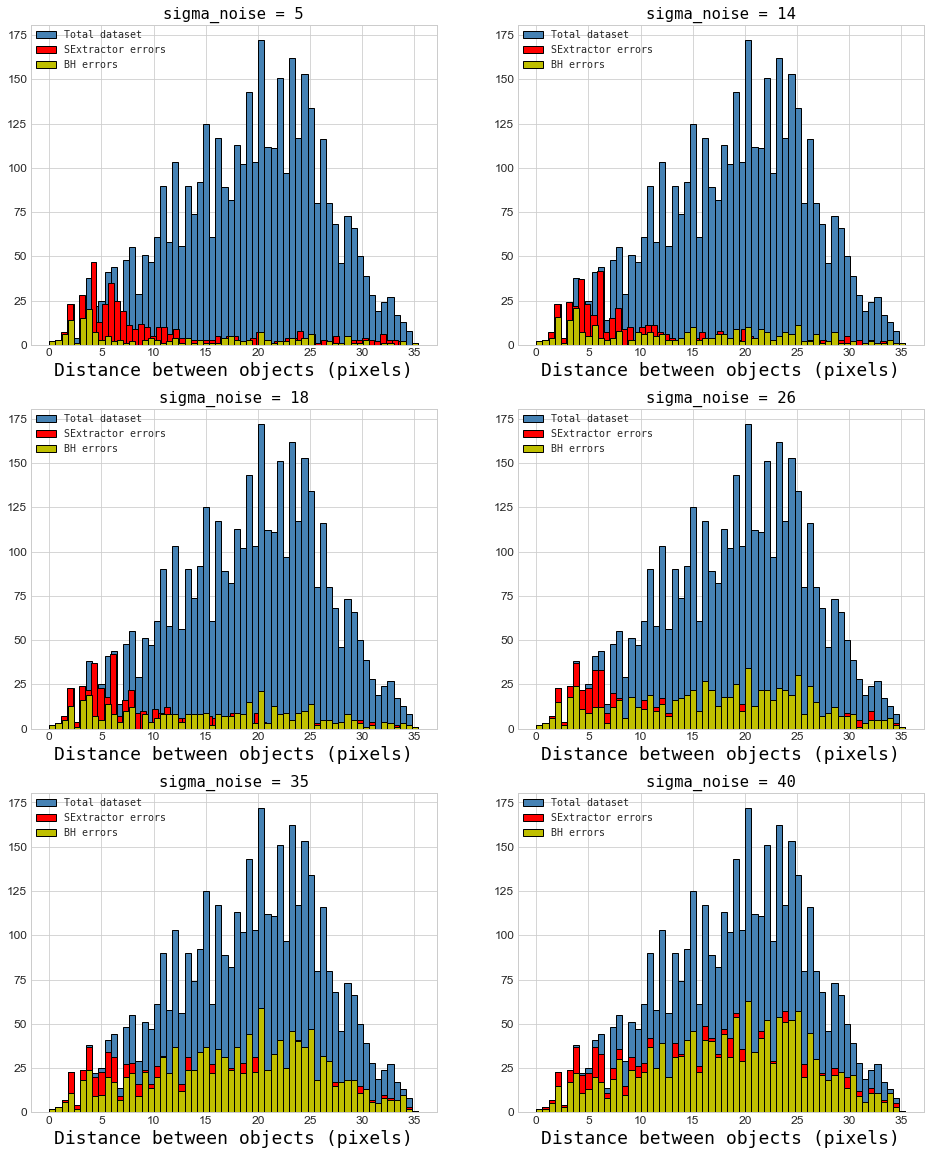

In [10]:
plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(3, 2, figsize=(16, 20), sharex=False)
axes = axes.ravel()

for ax, bh_data, sep_data, sigma_val in zip(axes, bh_res[:, 0, :4000], sep_res[:, 0, :4000], noise_sigma):
    
    make_hist(ax, dist, bh_data, sep_data, sigma_val)
    
plt.show()

In [55]:
def make_dist_acc_plot(ax, dist_bin_cent, bh_acc, sep_acc, sigma_val):
    
    font = {'family': 'monospace',
                'color':  'k',
                'weight': 'normal',
                'size': 18}

    ax.set_title('sigma_noise = {}'.format(sigma_val), fontdict=font, fontsize=18.5)
    ax.plot(dist_bin_cent, bh_acc, color = 'k', marker='.', label='BH')
    ax.plot(dist_bin_cent, sep_acc, color = 'steelblue', marker='.', label='SExtractor')
    ax.set_ylabel('Accuracy (%)', fontdict = font)
    ax.set_xlabel('Distance between objects (pixels)', fontdict = font)
    ax.set_ylim(0, 100)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.fill_between(dist_bin_cent, bh_acc, y2=sep_acc, where=bh_acc > sep_acc, interpolate=True, 
                    hatch="/", edgecolor="k", alpha=0.3, label='Gain on SExtractor')
    ax.legend(borderaxespad=0.1, loc="lower center", fontsize=18, prop={'family': 'monospace','size': 15})


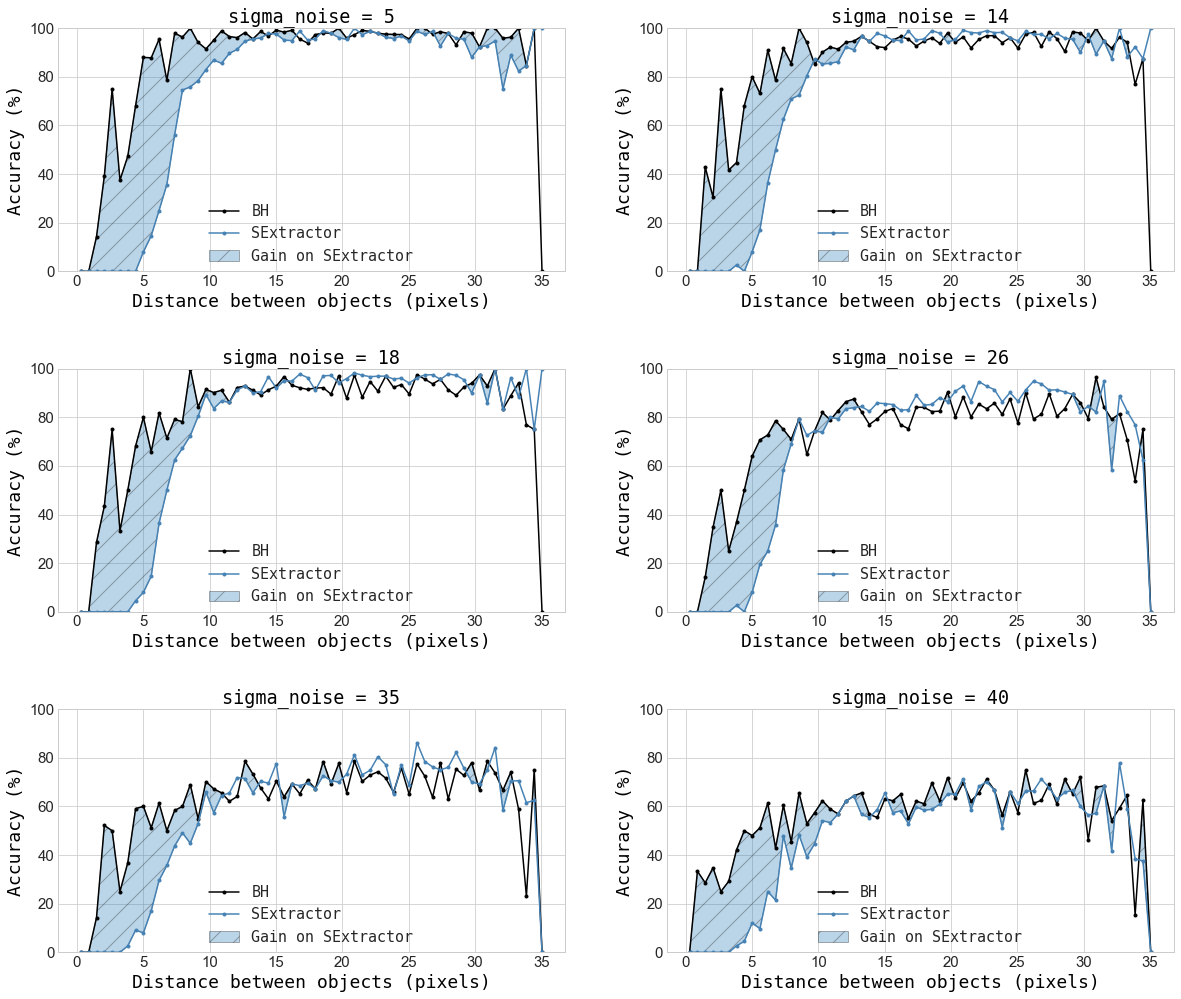

In [58]:
plt.style.use('seaborn-whitegrid')
fig, axes = plt.subplots(3, 2, figsize=(20, 17), sharex=False)
axes = axes.ravel()

dist_hist, dist_bins = np.histogram(dist, bins=60)
dist_bin_cent = dist_bins[:-1] + (dist_bins[1:] - dist_bins[:-1]) / 2

for ax, bh_data, sep_data, sigma_val in zip(axes, bh_res[:, 0, :4000], sep_res[:, 0, :4000], noise_sigma):
    
    bh_dist_hist, _ = np.histogram(dist[bh_data], bins=dist_bins)
    sep_dist_hist, _ = np.histogram(dist[sep_data], bins=dist_bins)
    
    bh_acc = bh_dist_hist / dist_hist * 100
    sep_acc = sep_dist_hist / dist_hist * 100
        
    make_dist_acc_plot(ax, dist_bin_cent, bh_acc, sep_acc, sigma_val)

plt.subplots_adjust(hspace=0.4)
plt.show()